## Simulating an IA Chatbot classifying intents of user utterances

A chatbot is simulated. Recent deployments of chatbot are looking at “Chatbots helping Agents, Agents Helping Chatbots.”  This architecture requires a seamless hand-off between agents and humans - CoChat: Enabling bot and human collaboration for task completion. Proc. AAAI 18, 5301 5308.

We use a widely used data set (ATIS) to simulate the scenario of identify the human-automation interaction - Characterit


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

### ATIS dataset
The ATIS data has the user entered text and the intent information

In [2]:
import json


# read file
with open('resources/MSDialog-Intent.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)
all_dialogs = obj['rasa_nlu_data']['common_examples']
sentences=[]
intents=[]
for obj in all_dialogs:
    sentences.append(obj['text'])
    intents.append(obj['intent'])

data_all = pd.DataFrame()
data_all['Sentence']  = sentences
data_all['Intent']  = intents
    

In [3]:
data_all.head(5)
data_all.Intent.value_counts()

flight                        3666
airfare                        423
ground_service                 255
airline                        157
abbreviation                   147
aircraft                        81
flight_time                     54
quantity                        51
flight+airfare                  21
distance                        20
airport                         20
city                            19
ground_fare                     18
capacity                        16
flight_no                       12
restriction                      6
meal                             6
airline+flight_no                2
airfare+flight_time              1
cheapest                         1
ground_service+ground_fare       1
aircraft+flight+flight_no        1
Name: Intent, dtype: int64

### Use NLP using spacy package

Create a tokenizer that takes and string and generates the tokens


In [4]:
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('C:/conda/anaconda3/lib/site-packages/en_core_web_sm/en_core_web_sm-2.2.5')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

### Clean the text 
Remove spaces, convert to lower case

In [5]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

### Transform the text into a vector
1. Clean the text
2. Tokenize the text
3. Generate a vector space model - vector with word frequency

Split the text into train and test data for training and cross validation

In [7]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))
from sklearn.model_selection import train_test_split

X = data_all["Sentence"] # the features we want to analyze
ylabels = data_all["Intent"] # the labels, or answers, we want to test against

X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)


### Train the classifier
Use logistic regression. Any classifier could be used. 
In this case, given that we are using bow, the performance of most classifiers will be similar
Our objective is not to train the best classifier but to show case the identification of levels of automation

In [8]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='lbfgs')

# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', bow_vector),
                 ('classifier', classifier)])

# model generation
pipe.fit(X_train,y_train)
    

C:\conda\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
         steps=[('cleaner', <__main__.predictors object at 0x0000016C28CD0B00>),
                ('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x0000016C21D6B158>,
                                 vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_

### Use the cross-validation test data
Run it through the same pipeline - cleaning, tokenizing, generating vectors and predicting 


Get the confusion matrix

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

# Model Accuracy


from sklearn.metrics import classification_report
report = classification_report(y_test, predicted, output_dict=True)

f1_dict = dict()
for key,val in report.items():
    if isinstance(val,dict):
        f1_dict[key] = val['f1-score']
        

        



C:\conda\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### ATIS Test Data - Unseen data to evaluate LOA
Get the test data

Predict the intent

Identify the performance of the intent classifier for each intent using the confusion matrix


In [11]:
# get the distribution of the test data and accuracy
#df = pd.DataFrame('pred':predicted)

with open('resources/MSDialog-Intent_test.json', 'r') as myfile:
    data=myfile.read()

# parse file
obj = json.loads(data)
all_dialogs = obj['rasa_nlu_data']['common_examples']
sentences=[]
intents=[]
for obj in all_dialogs:
    sentences.append(obj['text'])
    intents.append(obj['intent'])

data_test = pd.DataFrame()
data_test['Sentence']  = sentences
data_test['Intent']  = intents

X_unseen = data_test["Sentence"] # the features we want to analyze
y_unseen = data_test["Intent"] # the labels, or answers, we want to test against

pred = pipe.predict(X_unseen)




### Print LOA Histogram

    predicted    score              LOA
0      flight  0.95251  Full Automation
1      flight  0.95251  Full Automation
2      flight  0.95251  Full Automation
3      flight  0.95251  Full Automation
4      flight  0.95251  Full Automation
..        ...      ...              ...
888    flight  0.95251  Full Automation
889    flight  0.95251  Full Automation
890    flight  0.95251  Full Automation
891    flight  0.95251  Full Automation
892    flight  0.95251  Full Automation

[893 rows x 3 columns]


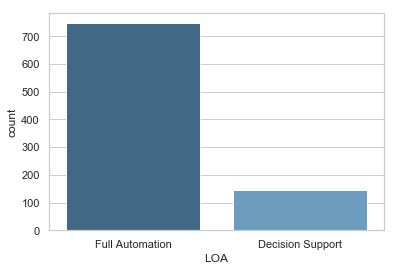

In [12]:
df = pd.DataFrame({'predicted': pred})
df['score']= df['predicted'].apply(lambda x: f1_dict[x])
df['LOA']=df['score'].apply(lambda x: 'Full Automation' if x >0.95 else 'Decision Support')
print(df)

import seaborn as sns
sns.set(style="whitegrid")
ax = sns.countplot(x="LOA",data=df,  palette="Blues_d")